In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score

In [3]:
# Load the dataset
dataframe = pd.read_csv('graded_exams.csv')

In [4]:
# Grading function based on the grade
def assign_grade(score):
    if 97 <= score <= 100:
        return 'Excellent'
    elif 93 <= score <= 96:
        return 'Superior'
    elif 89 <= score <= 92:
        return 'Good'
    elif 85 <= score <= 88:
        return 'Above Average'
    elif 81 <= score <= 84:
        return 'Average'
    elif 77 <= score <= 80:
        return 'Below Average'
    elif 73 <= score <= 76:
        return 'Passing'
    else:
        return 'Failure'

# Assign grades to each subject
dataframe['math_grade'] = dataframe['math score'].apply(assign_grade)
dataframe['reading_grade'] = dataframe['reading score'].apply(assign_grade)
dataframe['writing_grade'] = dataframe['writing score'].apply(assign_grade)

In [5]:
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=cmap)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [6]:
def prepare_features_and_target(dataframe, subject):
    X = dataframe.drop(columns=[f'{subject}_grade'])
    X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical features
    y = dataframe[f'{subject}_grade']
    return X, y

In [7]:
def encode_target_labels(y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return y_encoded, label_encoder

In [8]:
def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_test, X_unseen, y_test, y_unseen = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)
    return X_train, X_test, X_unseen, y_train, y_test, y_unseen

In [9]:
def scale_features(X_train, X_test, X_unseen):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_unseen_scaled = scaler.transform(X_unseen)
    return X_train_scaled, X_test_scaled, X_unseen_scaled

In [11]:
def process_subject(subject):
    X, y = prepare_features_and_target(dataframe, subject)
    y_encoded, label_encoder = encode_target_labels(y)
    X_train, X_test, X_unseen, y_train, y_test, y_unseen = split_data(X, y_encoded)
    X_train_scaled, X_test_scaled, X_unseen_scaled = scale_features(X_train, X_test, X_unseen)

    # Train Naive Bayes with cross-validation
    nb_model = GaussianNB()
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_acc = cross_val_score(nb_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation Accuracy (Mean) for {subject}: {np.mean(cross_val_acc):.4f}")

    # Train final model
    nb_model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_test_pred = nb_model.predict(X_test_scaled)
    y_test_proba = nb_model.predict_proba(X_test_scaled)

    # Evaluation on Test Data
    print(f"\n{subject} Test Data Evaluation:")
    print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred), 4))
    print("Precision:", round(precision_score(y_test, y_test_pred, average='weighted'), 4))
    print("Recall:", round(recall_score(y_test, y_test_pred, average='weighted'), 4))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_test_proba, multi_class='ovr'), 4))

    # Confusion matrix for test data
    plot_confusion_matrix(y_test, y_test_pred, f"Confusion Matrix - {subject} Test Set", 'Greens')

    # Predict on unseen data
    y_unseen_pred = nb_model.predict(X_unseen_scaled)
    y_unseen_proba = nb_model.predict_proba(X_unseen_scaled)

    # Evaluation on Unseen Data
    print(f"\n{subject} Unseen Data Evaluation:")
    print("Unseen Accuracy:", round(accuracy_score(y_unseen, y_unseen_pred), 4))
    print("Unseen Precision:", round(precision_score(y_unseen, y_unseen_pred, average='weighted'), 4))
    print("Unseen Recall:", round(recall_score(y_unseen, y_unseen_pred, average='weighted'), 4))
    print("Unseen ROC-AUC:", round(roc_auc_score(y_unseen, y_unseen_proba, multi_class='ovr'), 4))

    # Confusion matrix for unseen data
    plot_confusion_matrix(y_unseen, y_unseen_pred, f"Confusion Matrix - {subject} Unseen Data", 'Oranges')

Cross-validation Accuracy (Mean) for math: 0.8141

math Test Data Evaluation:
Test Accuracy: 0.785
Precision: 0.7982
Recall: 0.785
ROC-AUC: 0.9231


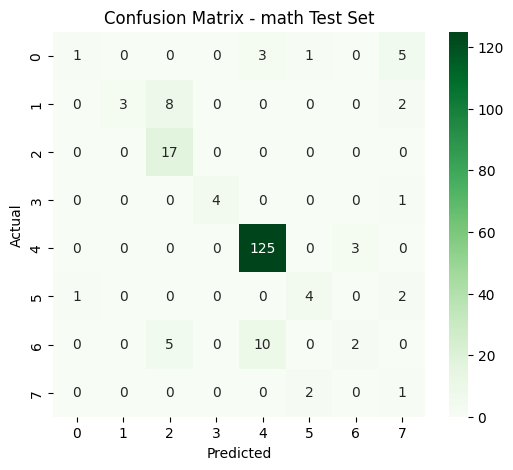


math Unseen Data Evaluation:
Unseen Accuracy: 0.81
Unseen Precision: 0.8226
Unseen Recall: 0.81
Unseen ROC-AUC: 0.9679


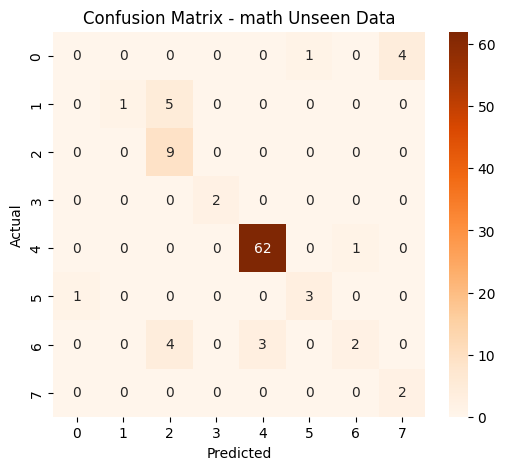

Cross-validation Accuracy (Mean) for reading: 0.7438

reading Test Data Evaluation:
Test Accuracy: 0.78
Precision: 0.7981
Recall: 0.78
ROC-AUC: 0.9558


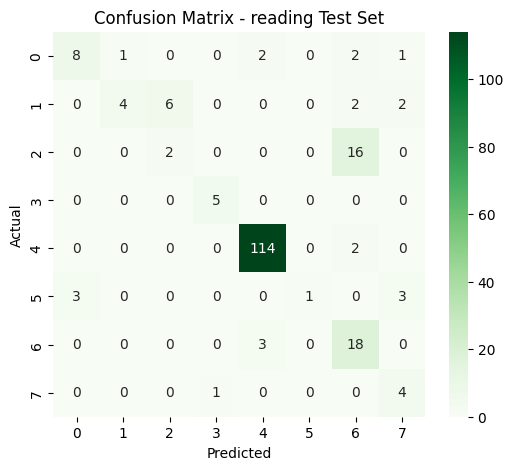


reading Unseen Data Evaluation:
Unseen Accuracy: 0.7
Unseen Precision: 0.724
Unseen Recall: 0.7
Unseen ROC-AUC: 0.96


c:\Users\Aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


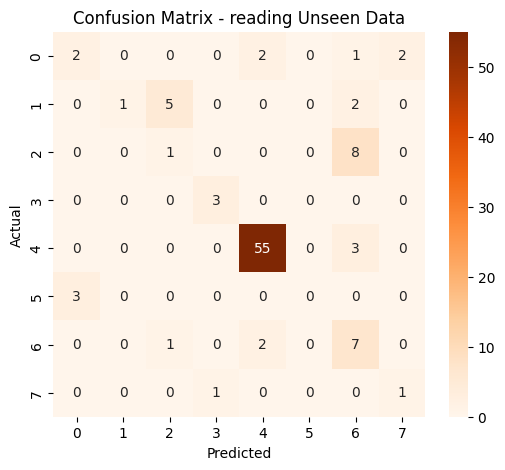

Cross-validation Accuracy (Mean) for writing: 0.8225

writing Test Data Evaluation:
Test Accuracy: 0.815
Precision: 0.7651
Recall: 0.815
ROC-AUC: 0.9506


c:\Users\Aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


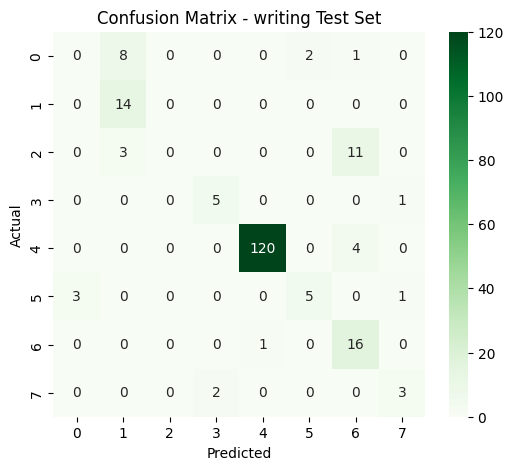


writing Unseen Data Evaluation:
Unseen Accuracy: 0.83
Unseen Precision: 0.7842
Unseen Recall: 0.83
Unseen ROC-AUC: 0.9473


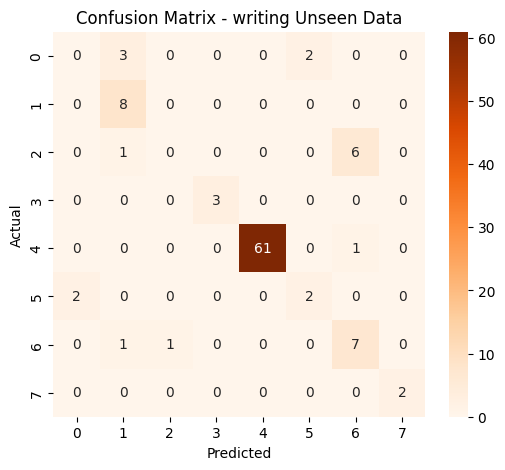

In [12]:
# Process each subject separately
for subject in ['math', 'reading', 'writing']:
    process_subject(subject)